## Synthetic Spectrum

Here we test VAMP on a synthetic spectrum of a massive central galaxy in the s43 SIMBA simulation, generated using [Pygad](https://bitbucket.org/broett/pygad/src/master/) for the CII 1036 Angstrom line.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from vpfits import *

import h5py

import gc

import corner

vpfits.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/sarah/miniconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/sarah/miniconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/sarah/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sarah/miniconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sarah/miniconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/h

First we will fit a metal spectrum. Load in the dataset and extract the data.

In [2]:
line = 1036. # angstroms

data = h5py.File('data/spectrum_pygad_CII1036.h5', 'r')
data.keys()

[u'density_col',
 u'flux',
 u'noise',
 u'tau',
 u'temp',
 u'velocity',
 u'wavelength']

In [3]:
wavelength = data['wavelength'][:]
flux = data['flux'][:]
noise = data['noise'][:]
taus = data['tau'][:]

nu = constants['c']['value'] / wavelength 

In [4]:
# Identify regions in the spectrum to fit

min_region_width = 2
regions, region_pixels = compute_detection_regions(wavelength, taus, flux, noise,
                                          min_region_width=min_region_width)

Computing detection regions...
Found 4 detection regions.


Plot the spectrum as frequency against flux, and see the regions we've identified:

In [5]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

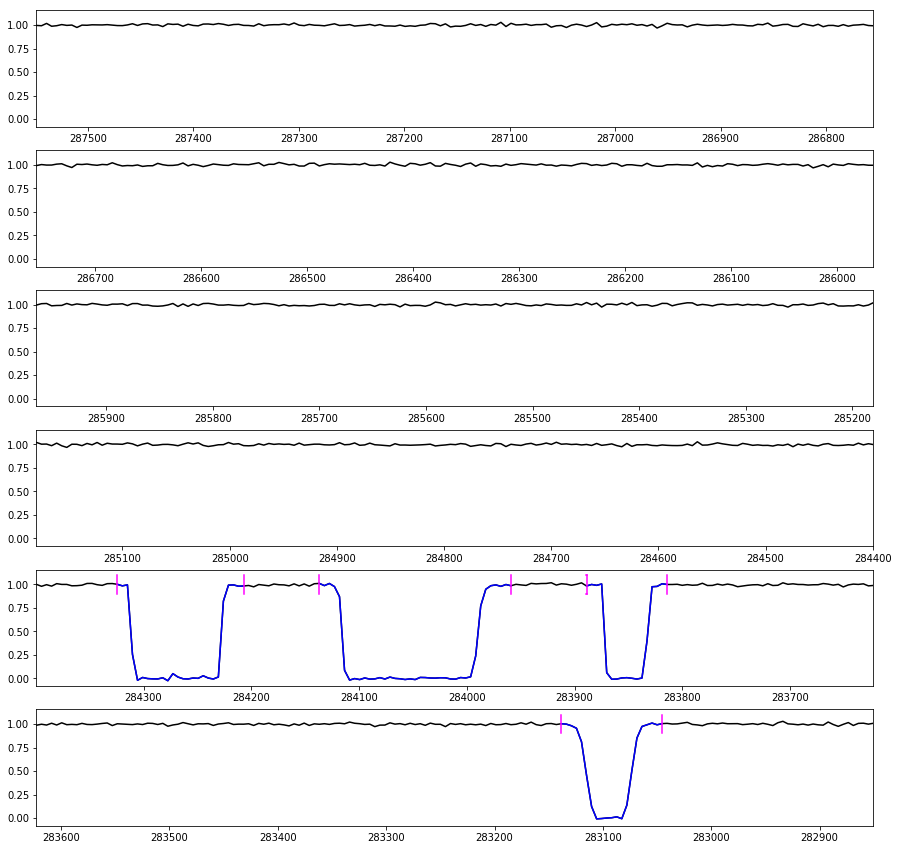

In [6]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

length = len(flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(nu, flux, c='black')
    
    ax[n].set_xlim(nu[lower_lim], nu[upper_lim])

    for (start, end) in region_pixels:
        ax[n].plot(nu[start:end+1], flux[start:end+1], color='blue')
        plot_bracket(nu[start], ax[n], 'left')
        plot_bracket(nu[end], ax[n], 'right')

plt.show()

Setting initial number of lines to: 1
Old BIC value of -6.84 is greater than the current -16.81.
Increasing the number of lines to: 3
Old BIC value of -16.81 is greater than the current -82.26.
Increasing the number of lines to: 4
Old BIC value of -82.26 is greater than the current -94.37.
Increasing the number of lines to: 5
BIC increased with increasing the line number, stopping.
Final n=4.


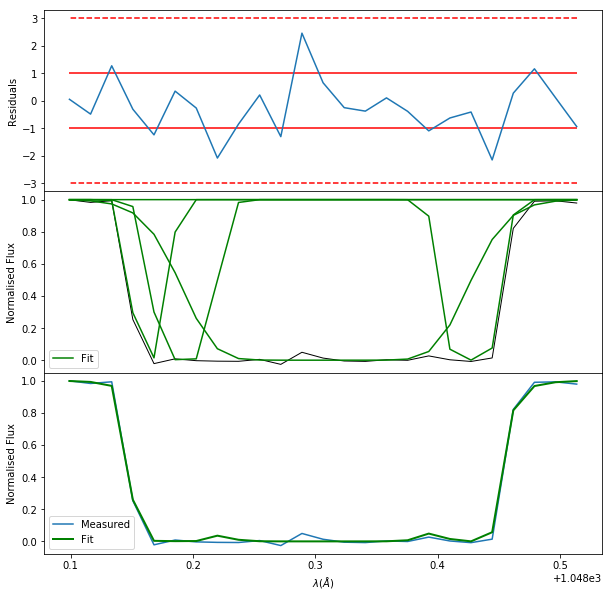

Setting initial number of lines to: 1
Old BIC value of -25.15 is greater than the current -53.79.
Increasing the number of lines to: 3
Old BIC value of -53.79 is greater than the current -185.31.
Increasing the number of lines to: 4
Old BIC value of -185.31 is greater than the current -198.63.
Reduced Chi squared is less than 1.
Final n=4


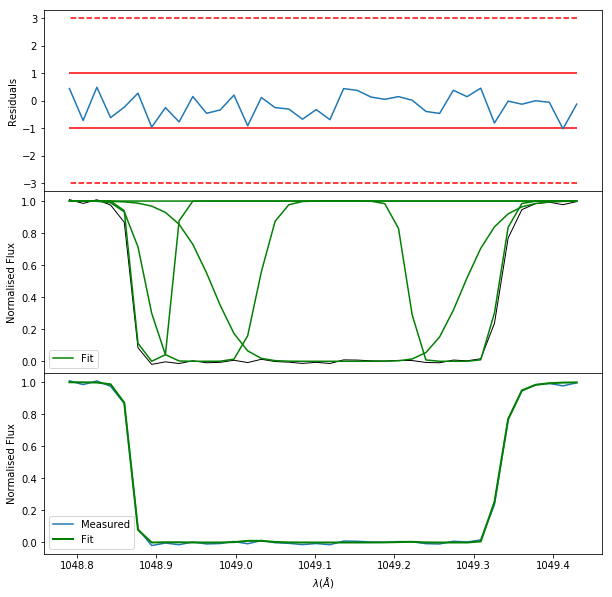

Setting initial number of lines to: 1
Old BIC value of -10.64 is greater than the current -17.60.
Increasing the number of lines to: 3
Old BIC value of -17.60 is greater than the current -66.81.
Increasing the number of lines to: 4
BIC increased with increasing the line number, stopping.
Final n=3.


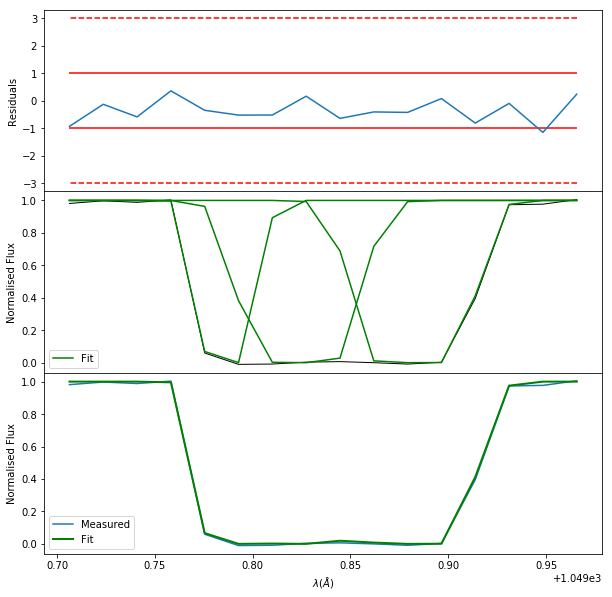

Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.


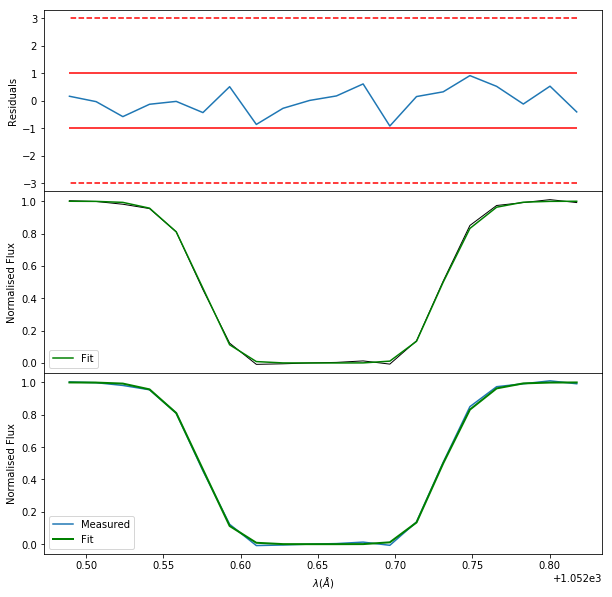

In [7]:
for start, end in region_pixels:
    wavelengths = np.flip(wavelength[start:end], 0)
    fluxes_orig = np.flip(flux[start:end], 0)
    fluxes = np.flip(flux[start:end], 0)
    nu_use = np.flip(nu[start:end], 0)
    noises = np.flip(noise[start:end], 0)

    n = estimate_n(fluxes)
    freedom = len(nu_use) + 3
    stuff = region_fit(nu_use, fluxes, n, noises, freedom)
    n = len(stuff.estimated_profiles)
    stuff.plot(wavelengths, fluxes_orig, n=n, start_pix=start, end_pix=end)
    

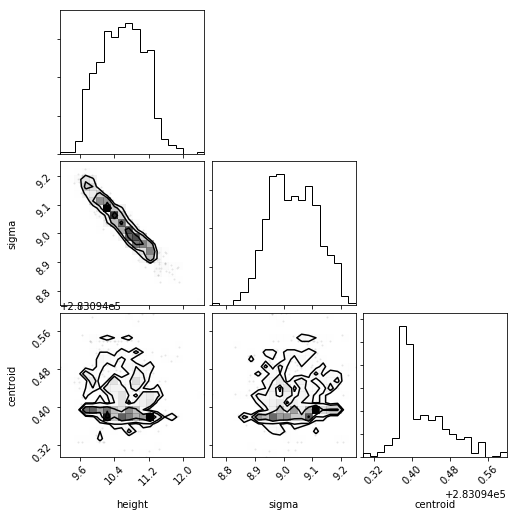

In [9]:
height_samples = stuff.mcmc.trace(stuff.estimated_variables[0]['amplitude'])[:]
sigma_samples = stuff.mcmc.trace(stuff.estimated_variables[0]['sigma'])[:]
centroid_samples = stuff.mcmc.trace(stuff.estimated_variables[0]['centroid'])[:]

samples = np.transpose(np.array([height_samples, sigma_samples, centroid_samples]))

fig = corner.corner(samples, labels=['height', 'sigma', 'centroid'])

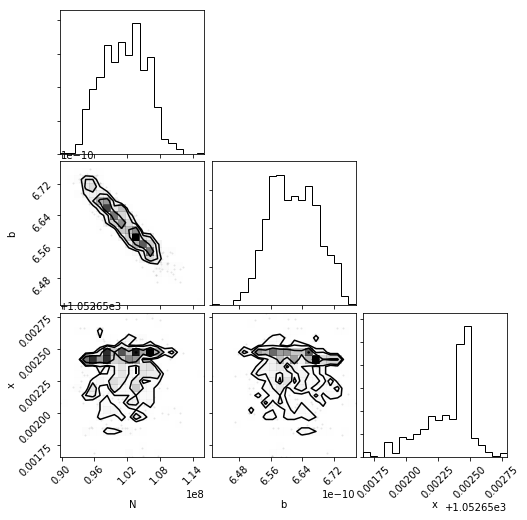

In [10]:
b = line*1.e-13*sigma_samples / np.sqrt(2)
N = height_samples*sigma_samples*np.sqrt(2*np.pi) / constants['sigma0']['value']

t = VPfit.GaussFunction(nu_use, height_samples[0], centroid_samples[0], sigma_samples[0])

l_centroids = constants['c']['value']/centroid_samples

phys_samples = np.transpose(np.array([N, b, l_centroids]))
fig = corner.corner(phys_samples, labels=['N', 'b', 'x'])

Now we will fit a Hydrogen spectrum, which requires a Voigt profile instead of a Gaussian. The extra parameter in the Voigt profile means this is slower than fitting a Gaussian.

In [7]:
line = 1215.

data = h5py.File('data/spectrum_pygad_H1215.h5', 'r')

wavelength = data['wavelength'][:]
flux = data['flux'][:]
noise = data['noise'][:]
taus = data['tau'][:]

nu = constants['c']['value'] / wavelength 

In [8]:
# Identify regions in the spectrum to fit

min_region_width = 2
regions, region_pixels = compute_detection_regions(wavelength, taus, flux, noise,
                                          min_region_width=min_region_width)

Computing detection regions...
Found 3 detection regions.


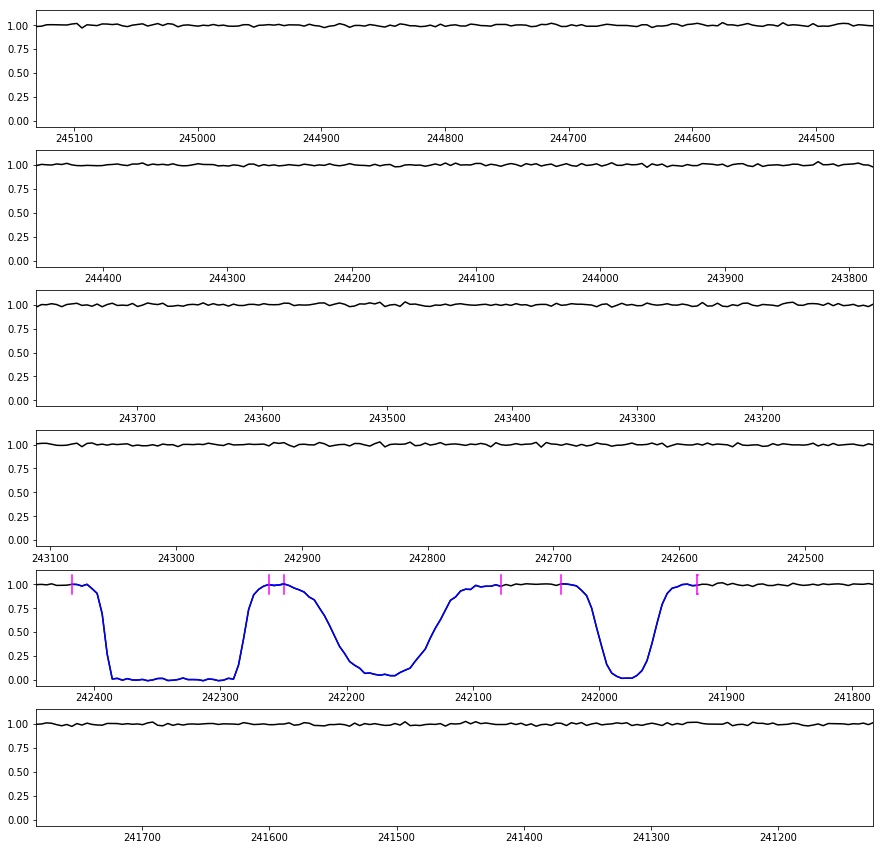

In [9]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

length = len(flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(nu, flux, c='black')
    
    ax[n].set_xlim(wavelength[lower_lim], wavelength[upper_lim])

    for (start, end) in region_pixels:
        ax[n].plot(wavelength[start:end+1], flux[start:end+1], color='blue')
        plot_bracket(wavelength[start], ax[n], 'left')
        plot_bracket(wavelength[end], ax[n], 'right')

plt.show()

Setting initial number of lines to: 1
Old BIC value of 2.35 is greater than the current -10.31.
Increasing the number of lines to: 3
Old BIC value of -10.31 is greater than the current -27.12.
Increasing the number of lines to: 4
Old BIC value of -27.12 is greater than the current -27.84.
Increasing the number of lines to: 5
Old BIC value of -27.84 is greater than the current -30.08.
Increasing the number of lines to: 6
BIC increased with increasing the line number, stopping.
Final n=5.


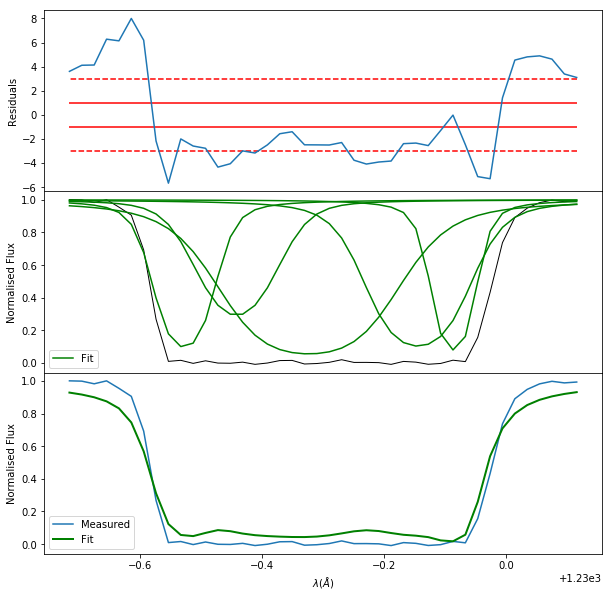

Setting initial number of lines to: 1
Old BIC value of -222.33 is greater than the current -226.22.
Increasing the number of lines to: 3
Old BIC value of -226.22 is greater than the current -233.02.
Increasing the number of lines to: 4
BIC increased with increasing the line number, stopping.
Final n=3.


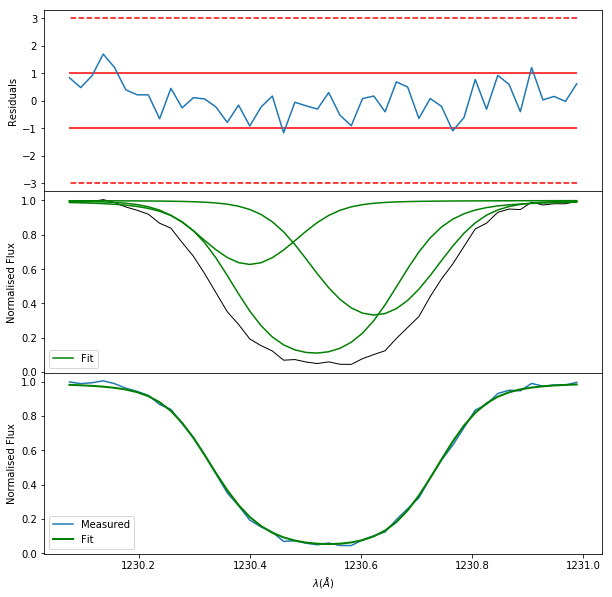

Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.


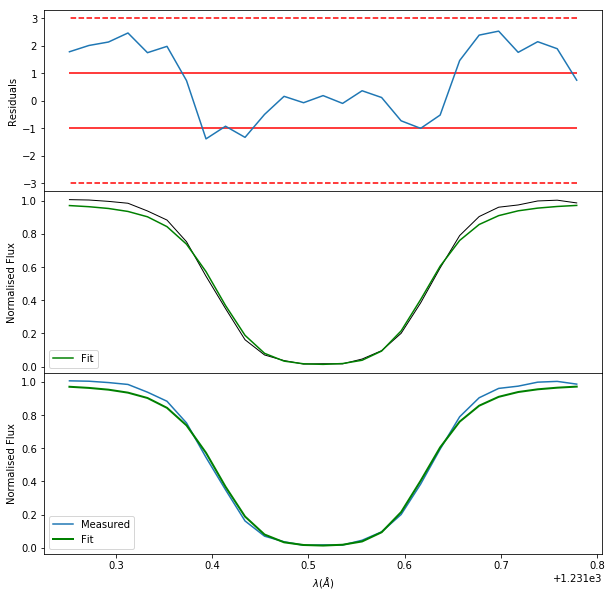

In [10]:
for start, end in region_pixels:
    wavelengths = np.flip(wavelength[start:end], 0)
    fluxes_orig = np.flip(flux[start:end], 0)
    fluxes = np.flip(flux[start:end], 0)
    nu_use = np.flip(nu[start:end], 0)
    noises = np.flip(noise[start:end], 0)

    n = estimate_n(fluxes)
    freedom = len(nu_use) + 3
    stuff = region_fit(nu_use, fluxes, n, noises, freedom, voigt=True)
    n = len(stuff.estimated_profiles)
    stuff.plot(wavelengths, fluxes_orig, n=n, start_pix=start, end_pix=end)
    

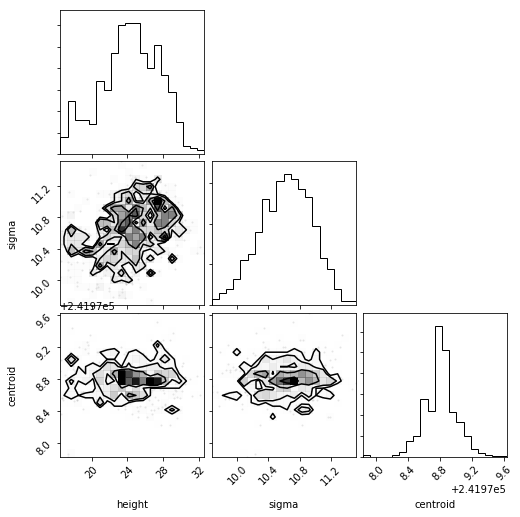

In [11]:
height_samples = stuff.mcmc.trace(stuff.estimated_variables[0]['amplitude'])[:]
gfwhm_samples = stuff.mcmc.trace(stuff.estimated_variables[0]['G_fwhm'])[:]
sigma_samples = stuff.GaussianWidth(gfwhm_samples)
centroid_samples = stuff.mcmc.trace(stuff.estimated_variables[0]['centroid'])[:]

samples = np.transpose(np.array([height_samples, sigma_samples, centroid_samples]))

fig = corner.corner(samples, labels=['height', 'sigma', 'centroid'])

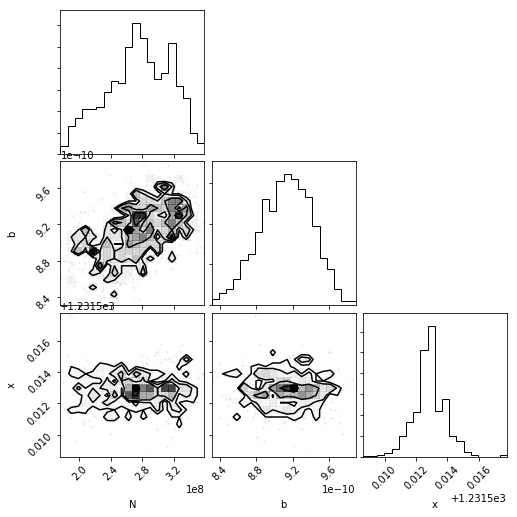

In [12]:
b = line*1.e-13*sigma_samples / np.sqrt(2)
N = height_samples*sigma_samples*np.sqrt(2*np.pi) / constants['sigma0']['value']

t = VPfit.GaussFunction(nu_use, height_samples[0], centroid_samples[0], sigma_samples[0])

l_centroids = constants['c']['value']/centroid_samples

phys_samples = np.transpose(np.array([N, b, l_centroids]))
fig = corner.corner(phys_samples, labels=['N', 'b', 'x'])